<a href="https://colab.research.google.com/github/yy0750/Stock-Price-Prediction-using-HMM-and-ARIMA/blob/main/GMMHMM_ARIMA_Stoc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Appendix A.1. Preparation for Model Construction/Modeling

#### Appendix A.1.1. Importing Necessary Modeules

In [1]:
!pip install hmmlearn
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.7 MB/s eta 0:00:00


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import yfinance as yf
import pmdarima as pm
from hmmlearn import hmm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import ndiffs
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [11]:
start_date = '2021-12-10'
end_date = '2023-11-17'

stock_code = '005930.KS' #Sk하이닉스: '000660.KS'
df = yf.download(stock_code, start=start_date, end=end_date)
df.reset_index(inplace=True)

df.insert(0, 'ID', df.index)
df.drop('Adj Close', axis=1, inplace=True)

[*********************100%%**********************]  1 of 1 completed


In [12]:
df.head()

,ID,Date,Open,High,Low,Close,Volume
0,0,2021-12-10,77400.0,77600.0,76800.0,76900.0,9155219
1,1,2021-12-13,77200.0,78300.0,76500.0,76800.0,15038750
2,2,2021-12-14,76500.0,77200.0,76200.0,77000.0,10976660
3,3,2021-12-15,76400.0,77600.0,76300.0,77600.0,9584939
4,4,2021-12-16,78500.0,78500.0,77400.0,77800.0,11996128


### Appendix A.1.3 Data formatting and Normalization

In [13]:
df['Avg'] = pd.Series([((row.Open + row.High + row.Low + row.Close)/4) for index, row in df.iterrows()])
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

X = df.values[:, [0, 7]]
X = np.nan_to_num(X)
X = StandardScaler().fit_transform(X)

#### Appendix A.1.4 Clustering
###### K-Means Clustering
###### Preliminary Clustering

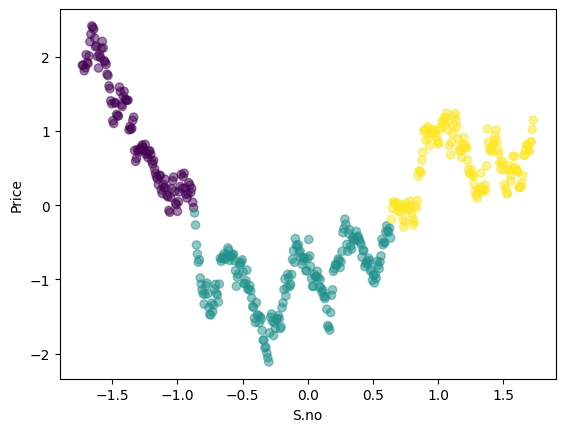

In [14]:
clusterNum = 3
k_means = KMeans(init = 'k-means++', n_clusters = clusterNum, n_init = 12)
k_means.fit(X)
labels = k_means.labels_

df['State'] = labels

plt.scatter(X[:, 0], X[:, 1], c=labels.astype(np.float64), alpha=0.5);
plt.xlabel('S.no');
plt.ylabel('Price');

In [15]:
pre_means = []
pre_covars = []

for i in [0, 1, 2]:
    tdf = df[df.State == i]

    pre_means.append(tdf['Avg'].sum() / tdf['Avg'].count())
    pre_covars.append(tdf['Avg'].std() ** 2)

##### Clustering the log-likelihoods


In [16]:
pre_prices = df['Avg'].tolist()

pre_training_ll = [np.nan] * len(pre_prices)

for i in range(3, len(pre_prices)): #Method 1
#for i in range(len(pre_prices)): #Method 2
    print('Datapoint: ', i)
    #Initialize
    pre_model = hmm.GMMHMM(n_components = 3, n_mix=1, n_iter = 100, covariance_type='diag', init_params='')
    pre_model.startprob_ = np.array([1/3, 1/3, 1/3])
    pre_model.transmat_ = np.array([[1/3, 1/3, 1/3], [1/3, 1/3, 1/3], [1/3, 1/3, 1/3]])
    pre_model.means_ = np.array([pre_means[0], pre_means[1], pre_means[2]]).reshape(3, 1, 1)
    pre_model.covars_ = np.array([pre_covars[0], pre_covars[1], pre_covars[2]]).reshape(3, 1, 1)
    pre_model.weights_ = np.array([1, 1, 1]).reshape(3,1)

    #Samples
    X = np.array(pre_prices[max(i-4, 0):i]).reshape(i - max(i-4, 0), 1)

    #Method 2
    #X = np.array([df['Open'][i], df['Close'][i], df['High'][i], df['Low'][i]]).reshape(4, 1)

    X = np.nan_to_num(X)

    # Training
    try:
        pre_model.fit(X)
    except ValueError:
        continue

    pre_training_ll[i] = pre_model.monitor_.history[0]

df['pre_ll'] = np.nan_to_num(pre_training_ll)

Datapoint:  3
Datapoint:  4
Datapoint:  5
Datapoint:  6
Datapoint:  7
Datapoint:  8
Datapoint:  9


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d


Datapoint:  10
Datapoint:  11


Datapoint:  12
Datapoint:  13
Datapoint:  14
Datapoint:  15
Datapoint:  16
Datapoint:  17


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d


Datapoint:  18
Datapoint:  19
Datapoint:  20
Datapoint:  21


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d


Datapoint:  22
Datapoint:  23
Datapoint:  24
Datapoint:  25
Datapoint:  26


Datapoint:  27
Datapoint:  28
Datapoint:  29
Datapoint:  30
Datapoint:  31


Datapoint:  32
Datapoint:  33
Datapoint:  34


Datapoint:  35
Datapoint:  36
Datapoint:  37
Datapoint:  38
Datapoint:  39


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d


Datapoint:  40
Datapoint:  41
Datapoint:  42


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:744: RuntimeWarning: invalid value encountered in divide
  self.weights_ = w_n / w_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:756: RuntimeWarning: invalid value encountered in divide
  self.means_ = m_n / m_d[:, :, None]
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:744: RuntimeWarning: invalid value encountered in divide
  self.weights_ = w_n / w_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:756: RuntimeWarning: invalid value encountered in divide
  self.means_ = m_n / m_d[:, :, None]


Datapoint:  43
Datapoint:  44
Datapoint:  45
Datapoint:  46
Datapoint:  47


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:744: RuntimeWarning: invalid value encountered in divide
  self.weights_ = w_n / w_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:756: RuntimeWarning: invalid value encountered in divide
  self.means_ = m_n / m_d[:, :, None]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Datapoint:  48
Datapoint:  49
Datapoint:  50


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:744: RuntimeWarning: invalid value encountered in divide
  self.weights_ = w_n / w_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:756: RuntimeWarning: invalid value encountered in divide
  self.means_ = m_n / m_d[:, :, None]


Datapoint:  51
Datapoint:  52
Datapoint:  53
Datapoint:  54
Datapoint:  55
Datapoint:  56


Datapoint:  57
Datapoint:  58
Datapoint:  59
Datapoint:  60
Datapoint:  61


Datapoint:  62
Datapoint:  63
Datapoint:  64
Datapoint:  65
Datapoint:  66
Datapoint:  67


Datapoint:  68
Datapoint:  69
Datapoint:  70
Datapoint:  71
Datapoint:  72
Datapoint:  73
Datapoint:  74


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:744: RuntimeWarning: invalid value encountered in divide
  self.weights_ = w_n / w_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:756: RuntimeWarning: invalid value encountered in divide
  self.means_ = m_n / m_d[:, :, None]


Datapoint:  75
Datapoint:  76
Datapoint:  77
Datapoint:  78
Datapoint:  79


Datapoint:  80
Datapoint:  81
Datapoint:  82
Datapoint:  83
Datapoint:  84
Datapoint:  85
Datapoint:  86


Datapoint:  87
Datapoint:  88
Datapoint:  89
Datapoint:  90
Datapoint:  91
Datapoint:  92


Datapoint:  93
Datapoint:  94
Datapoint:  95
Datapoint:  96
Datapoint:  97
Datapoint:  98


Datapoint:  99
Datapoint:  100
Datapoint:  101
Datapoint:  102


Datapoint:  103
Datapoint:  104


Datapoint:  105


Datapoint:  106
Datapoint:  107


Datapoint:  108


Datapoint:  109
Datapoint:  110
Datapoint:  111


Datapoint:  112
Datapoint:  113
Datapoint:  114
Datapoint:  115
Datapoint:  116
Datapoint:  117


Datapoint:  118
Datapoint:  119
Datapoint:  120
Datapoint:  121
Datapoint:  122
Datapoint:  123


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d


Datapoint:  124
Datapoint:  125
Datapoint:  126


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:744: RuntimeWarning: invalid value encountered in divide
  self.weights_ = w_n / w_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:756: RuntimeWarning: invalid value encountered in divide
  self.means_ = m_n / m_d[:, :, None]


Datapoint:  127


Datapoint:  128
Datapoint:  129
Datapoint:  130


Datapoint:  131
Datapoint:  132
Datapoint:  133
Datapoint:  134
Datapoint:  135
Datapoint:  136


Datapoint:  137
Datapoint:  138
Datapoint:  139
Datapoint:  140
Datapoint:  141
Datapoint:  142
Datapoint:  143


Datapoint:  144
Datapoint:  145
Datapoint:  146
Datapoint:  147
Datapoint:  148
Datapoint:  149


Datapoint:  150
Datapoint:  151
Datapoint:  152
Datapoint:  153
Datapoint:  154
Datapoint:  155
Datapoint:  156


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d


Datapoint:  157
Datapoint:  158
Datapoint:  159
Datapoint:  160


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d


Datapoint:  161
Datapoint:  162
Datapoint:  163
Datapoint:  164


Datapoint:  165
Datapoint:  166
Datapoint:  167
Datapoint:  168
Datapoint:  169
Datapoint:  170
Datapoint:  171


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:744: RuntimeWarning: invalid value encountered in divide
  self.weights_ = w_n / w_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:756: RuntimeWarning: invalid value encountered in divide
  self.means_ = m_n / m_d[:, :, None]


Datapoint:  172
Datapoint:  173
Datapoint:  174


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d


Datapoint:  175
Datapoint:  176
Datapoint:  177
Datapoint:  178


Datapoint:  179
Datapoint:  180
Datapoint:  181
Datapoint:  182
Datapoint:  183
Datapoint:  184


Datapoint:  185
Datapoint:  186
Datapoint:  187
Datapoint:  188
Datapoint:  189
Datapoint:  190
Datapoint:  191


Datapoint:  192
Datapoint:  193
Datapoint:  194
Datapoint:  195
Datapoint:  196
Datapoint:  197
Datapoint:  198


Datapoint:  199
Datapoint:  200
Datapoint:  201
Datapoint:  202
Datapoint:  203
Datapoint:  204
Datapoint:  205


Datapoint:  206
Datapoint:  207
Datapoint:  208
Datapoint:  209
Datapoint:  210
Datapoint:  211
Datapoint:  212


Datapoint:  213
Datapoint:  214
Datapoint:  215
Datapoint:  216
Datapoint:  217
Datapoint:  218


Datapoint:  219
Datapoint:  220
Datapoint:  221
Datapoint:  222
Datapoint:  223
Datapoint:  224
Datapoint:  225


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d


Datapoint:  226
Datapoint:  227
Datapoint:  228


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d


Datapoint:  229
Datapoint:  230
Datapoint:  231
Datapoint:  232


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d


Datapoint:  233
Datapoint:  234
Datapoint:  235
Datapoint:  236


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d


Datapoint:  237
Datapoint:  238
Datapoint:  239
Datapoint:  240


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d


Datapoint:  241
Datapoint:  242
Datapoint:  243


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d


Datapoint:  244
Datapoint:  245
Datapoint:  246
Datapoint:  247


Datapoint:  248
Datapoint:  249
Datapoint:  250
Datapoint:  251
Datapoint:  252
Datapoint:  253
Datapoint:  254


Datapoint:  255
Datapoint:  256
Datapoint:  257
Datapoint:  258
Datapoint:  259
Datapoint:  260
Datapoint:  261


Datapoint:  262
Datapoint:  263
Datapoint:  264
Datapoint:  265
Datapoint:  266
Datapoint:  267


Datapoint:  268
Datapoint:  269
Datapoint:  270
Datapoint:  271
Datapoint:  272
Datapoint:  273


Datapoint:  274
Datapoint:  275
Datapoint:  276
Datapoint:  277
Datapoint:  278


Datapoint:  279
Datapoint:  280
Datapoint:  281
Datapoint:  282
Datapoint:  283


Datapoint:  284
Datapoint:  285
Datapoint:  286
Datapoint:  287
Datapoint:  288


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:744: RuntimeWarning: invalid value encountered in divide
  self.weights_ = w_n / w_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:756: RuntimeWarning: invalid value encountered in divide
  self.means_ = m_n / m_d[:, :, None]


Datapoint:  289
Datapoint:  290
Datapoint:  291
Datapoint:  292


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d


Datapoint:  293
Datapoint:  294
Datapoint:  295
Datapoint:  296
Datapoint:  297


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:744: RuntimeWarning: invalid value encountered in divide
  self.weights_ = w_n / w_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:756: RuntimeWarning: invalid value encountered in divide
  self.means_ = m_n / m_d[:, :, None]


Datapoint:  298
Datapoint:  299
Datapoint:  300


Datapoint:  301


Datapoint:  302
Datapoint:  303
Datapoint:  304
Datapoint:  305
Datapoint:  306
Datapoint:  307


Datapoint:  308
Datapoint:  309
Datapoint:  310
Datapoint:  311
Datapoint:  312
Datapoint:  313
Datapoint:  314


Datapoint:  315
Datapoint:  316
Datapoint:  317
Datapoint:  318


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d


Datapoint:  319
Datapoint:  320


Datapoint:  321


Datapoint:  322
Datapoint:  323


Datapoint:  324
Datapoint:  325


Datapoint:  326
Datapoint:  327


Datapoint:  328
Datapoint:  329
Datapoint:  330


Datapoint:  331
Datapoint:  332
Datapoint:  333
Datapoint:  334
Datapoint:  335
Datapoint:  336


Datapoint:  337
Datapoint:  338
Datapoint:  339
Datapoint:  340
Datapoint:  341
Datapoint:  342


Datapoint:  343
Datapoint:  344
Datapoint:  345
Datapoint:  346
Datapoint:  347
Datapoint:  348


Datapoint:  349
Datapoint:  350
Datapoint:  351
Datapoint:  352
Datapoint:  353
Datapoint:  354


Datapoint:  355
Datapoint:  356
Datapoint:  357
Datapoint:  358
Datapoint:  359


Datapoint:  360
Datapoint:  361
Datapoint:  362
Datapoint:  363
Datapoint:  364


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d


Datapoint:  365
Datapoint:  366
Datapoint:  367
Datapoint:  368


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d


Datapoint:  369
Datapoint:  370
Datapoint:  371
Datapoint:  372


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d


Datapoint:  373


Datapoint:  374
Datapoint:  375
Datapoint:  376


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d


Datapoint:  377


Datapoint:  378
Datapoint:  379


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d


Datapoint:  380
Datapoint:  381
Datapoint:  382
Datapoint:  383


Datapoint:  384
Datapoint:  385
Datapoint:  386
Datapoint:  387


Datapoint:  388
Datapoint:  389
Datapoint:  390


Datapoint:  391
Datapoint:  392
Datapoint:  393


Datapoint:  394
Datapoint:  395


Datapoint:  396
Datapoint:  397


Datapoint:  398
Datapoint:  399


Datapoint:  400


Datapoint:  401
Datapoint:  402
Datapoint:  403


Datapoint:  404
Datapoint:  405
Datapoint:  406
Datapoint:  407


Datapoint:  408


Datapoint:  409
Datapoint:  410
Datapoint:  411


Datapoint:  412
Datapoint:  413
Datapoint:  414
Datapoint:  415


Datapoint:  416
Datapoint:  417
Datapoint:  418
Datapoint:  419
Datapoint:  420
Datapoint:  421


Datapoint:  422
Datapoint:  423
Datapoint:  424
Datapoint:  425
Datapoint:  426
Datapoint:  427


Datapoint:  428
Datapoint:  429
Datapoint:  430
Datapoint:  431
Datapoint:  432


Datapoint:  433
Datapoint:  434
Datapoint:  435
Datapoint:  436
Datapoint:  437
Datapoint:  438


Datapoint:  439
Datapoint:  440
Datapoint:  441
Datapoint:  442


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d


Datapoint:  443
Datapoint:  444
Datapoint:  445


Datapoint:  446
Datapoint:  447
Datapoint:  448
Datapoint:  449
Datapoint:  450


Datapoint:  451
Datapoint:  452
Datapoint:  453
Datapoint:  454
Datapoint:  455


Datapoint:  456
Datapoint:  457
Datapoint:  458
Datapoint:  459
Datapoint:  460


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:744: RuntimeWarning: invalid value encountered in divide
  self.weights_ = w_n / w_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:756: RuntimeWarning: invalid value encountered in divide
  self.means_ = m_n / m_d[:, :, None]


Datapoint:  461
Datapoint:  462
Datapoint:  463
Datapoint:  464
Datapoint:  465


Datapoint:  466
Datapoint:  467
Datapoint:  468
Datapoint:  469
Datapoint:  470
Datapoint:  471


Datapoint:  472
Datapoint:  473
Datapoint:  474


##### Refining the clusters (Clustering the log_likelihoods):

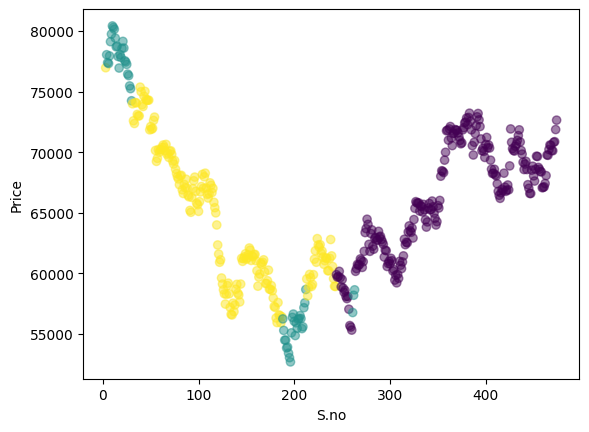

In [17]:
X = df.values[3:, [0, 9]] #Method 1
#X = df.values[:, [0, 9]] #Method 2
X = np.nan_to_num(X)
X = StandardScaler().fit_transform(X)

clusterNum = 3
k_means = KMeans(init = 'k-means++', n_clusters = clusterNum, n_init = 12)
k_means.fit(X)
labels = k_means.labels_

#세 개의 행 삭제
df = df.drop([0, 1, 2]) #Method 1

df['State'] = labels

plt.scatter(df['ID'], df['Avg'], c=df['State'].astype(np.float64), alpha=0.5);
plt.xlabel('S.no');
plt.ylabel('Price');

## Appendix A.2. Model Construction/Modeling


#### Appendix A.2.1 Mixture Model
##### Low Economy

<ipython-input-18-18094e1c0f12>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_df.drop(['ID'], axis=1, inplace=True)
<ipython-input-18-18094e1c0f12>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_df['ID'] = low_df.index
<ipython-input-18-18094e1c0f12>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_df['Mix

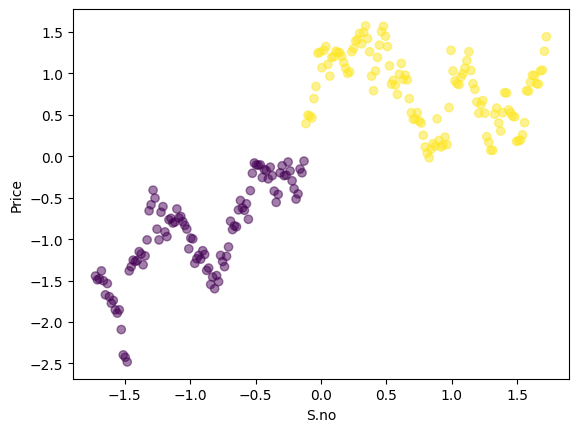

In [18]:
low_df = df[df.State == 0]

low_df.reset_index(inplace=True)
low_df.drop(['ID'], axis=1, inplace=True)
low_df['ID'] = low_df.index

X = low_df.values[:, [10, 7]]
X = np.nan_to_num(X)
X = StandardScaler().fit_transform(X)

clusterNum = 2
low_k_means = KMeans(init='k-means++', n_clusters=clusterNum, n_init=12)
low_k_means.fit(X)
labels = low_k_means.labels_
low_df['Mix'] = labels

plt.scatter(X[:, 0], X[:, 1], c=labels.astype(np.float64), alpha=0.5);
plt.xlabel('S.no');
plt.ylabel('Price');

low_means = []
low_covars = []
low_weights = []

for i in [0, 1]:
    tdf = low_df[low_df.Mix == i]

    #Mean
    low_means.append(tdf['Avg'].sum() / tdf['Avg'].count())

    #Variance
    low_covars.append(tdf['Avg'].std() ** 2)

    #Weights
    tdf = low_df[low_df.Mix == 0]
    low_weights.append(tdf['Avg'].count() / low_df['Avg'].count())
    low_weights.append(1 - low_weights[0])

##### Medium Economy

<ipython-input-19-9acbba666d0d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medium_df.drop(['ID'], axis=1, inplace=True)
<ipython-input-19-9acbba666d0d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medium_df['ID'] = medium_df.index
<ipython-input-19-9acbba666d0d>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  me

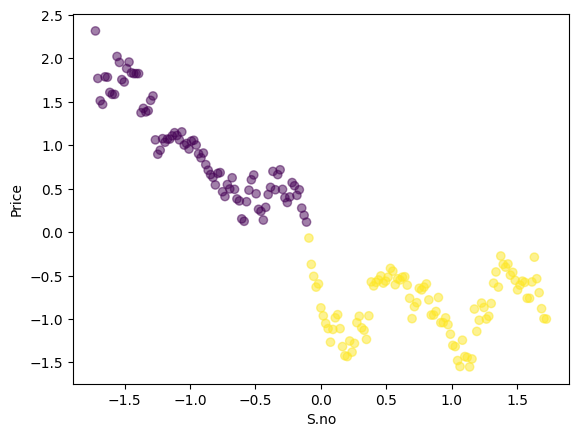

In [19]:
medium_df = df[df.State == 2]

medium_df.reset_index(inplace=True)
medium_df.drop(['ID'], axis=1, inplace=True)
medium_df['ID'] = medium_df.index

X = medium_df.values[:, [10, 7]]
X = np.nan_to_num(X)
X = StandardScaler().fit_transform(X)

clusterNum = 2
medium_k_means = KMeans(init='k-means++', n_clusters=clusterNum, n_init=12)
medium_k_means.fit(X)
labels = medium_k_means.labels_
medium_df['Mix'] = labels

plt.scatter(X[:, 0], X[:, 1], c=labels.astype(np.float64), alpha=0.5)
plt.xlabel('S.no')
plt.ylabel('Price')

medium_means = []
medium_covars = []
medium_weights = []

for i in [0, 1]:
    tdf = medium_df[medium_df.Mix == i]

    #Mean
    medium_means.append(tdf['Avg'].sum() / tdf['Avg'].count())

    #Variance
    medium_covars.append(tdf['Avg'].std() ** 2)

    #Weights
    tdf = medium_df[medium_df.Mix == 0]
    medium_weights.append(tdf['Avg'].count() / medium_df['Avg'].count())
    medium_weights.append(1 - medium_weights[0])

##### High Economy

<ipython-input-20-5f15762a6f4f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_df.drop(['ID'], axis=1, inplace=True)
<ipython-input-20-5f15762a6f4f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_df['ID'] = high_df.index
<ipython-input-20-5f15762a6f4f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_df[

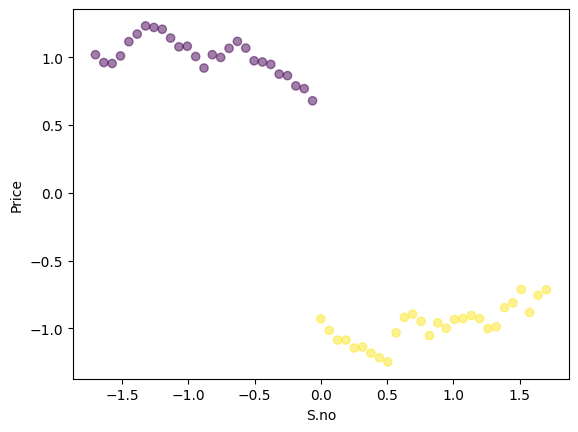

In [20]:
high_df = df[df.State == 1]

high_df.reset_index(inplace=True)
high_df.drop(['ID'], axis=1, inplace=True)
high_df['ID'] = high_df.index

X = high_df.values[:, [10, 7]]
X = np.nan_to_num(X)
X = StandardScaler().fit_transform(X)

clusterNum = 2
high_K_means = KMeans(init = 'k-means++', n_clusters = clusterNum, n_init = 12)
high_K_means.fit(X)
labels = high_K_means.labels_
high_df['Mix'] = labels

plt.scatter(X[:, 0], X[:, 1], c=labels.astype(np.float64), alpha=0.5)
plt.xlabel('S.no')
plt.ylabel('Price')

high_means = []
high_covars = []
high_weights = []

for i in [0, 1]:
    tdf = high_df[high_df.Mix == i]

    #Mean
    high_means.append(tdf['Avg'].sum() / tdf['Avg'].count())

    #Variance
    high_covars.append(tdf['Avg'].std() ** 2)

    #Weights
    tdf = high_df[high_df.Mix == 0]
    high_weights.append(tdf['Avg'].count() / high_df['Avg'].count())
    high_weights.append(1 - high_weights[0])

#### Appendix A.2.2 HMM Training and Testing

In [21]:
prices = df['Close'].tolist()

training_ll = [None] * len(prices)
lls = [None] * len(prices)
predicted_prices = [None] * (len(prices)+1)
epsilon = 0.2
curr_ll = 0

for i in range(3, len(prices)): #{for i in range(len(prices)):} - Method 2
    print('Datapoint: ', i)
    #Initialize
    model = hmm.GMMHMM(n_components=3, n_mix=2, n_iter=100, covariance_type='diag', init_params='')
    model.startprob_ = np.array([1/3, 1/3, 1/3])
    model.transmat_ = np.array([[1/3, 1/3, 1/3], [1/3, 1/3, 1/3], [1/3, 1/3, 1/3]])

    model.means_ = np.array([[medium_means[0], medium_means[1]], [high_means[0], high_means[1]], [low_means[0], low_means[1]]]).reshape(3, 2, 1)
    model.covars_ = np.array([[medium_covars[0], medium_covars[1]], [high_covars[0], high_covars[1]], [low_covars[0], low_covars[1]]]).reshape(3, 2, 1)
    model.weights_ = np.array([[medium_weights[0], medium_weights[1]], [high_weights[0], high_weights[1]], [low_weights[0], low_weights[1]]])

    #Samples
    X = np.array(prices[max(i-4, 0):i]).reshape(i - max(i-4, 0),1)

    #Method 2
    #X = np.array([df['Open'][i], df['Close'][i], df['High'][i], df['Low'][i]]).reshape(4, 1)
    X = np.nan_to_num(X)

    #Training
    try:
        model.fit(X)
    except ValueError:
        pass


    ll_arr = np.array(model.monitor_.history)
    ll_arr = ll_arr[~np.isnan(ll_arr)]

    # Log-likelihood
    try:
        #curr_ll = ll_arr[0] # - First Iteration
        #curr_ll = np.median(ll_arr) # - Middle Iteration
        curr_ll = ll_arr[-1] # - Last Iteration
    except ValueError:
        pass

    lls[i] = (curr_ll)

    #Predict
    if i > 427:
        diff = []
        for j in range(3, i): #{for j in range(i):} - Method 2
            if lls[j] != None:
                if lls[j] < (curr_ll + epsilon) and lls[j] > (curr_ll - epsilon):
                    diff.append(prices[j+1] - prices[j])

        if len(diff) > 0:
            min_diff = diff[np.argmin(np.abs(diff))]
            predicted_prices[i+1] = prices[i] + min_diff

df['PredictedPrices'] = pd.Series(predicted_prices)

/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  3
Datapoint:  4


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  5
Datapoint:  6


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  7
Datapoint:  8


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  9
Datapoint:  10


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  11
Datapoint:  12


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  13
Datapoint:  14


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  15
Datapoint:  16


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  17
Datapoint:  18


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions

Datapoint:  19
Datapoint:  20


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ 

Datapoint:  21
Datapoint:  22


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  23
Datapoint:  24


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  25
Datapoint:  26


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  27
Datapoint:  28


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions

Datapoint:  29
Datapoint:  30


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ 

Datapoint:  31
Datapoint:  32


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ 

Datapoint:  33
Datapoint:  34


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ 

Datapoint:  35
Datapoint:  36


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  37


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Nu

Datapoint:  38
Datapoint:  39


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions

Datapoint:  40
Datapoint:  41


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ 

Datapoint:  42
Datapoint:  43


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions

Datapoint:  44
Datapoint:  45


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1033: Convergenc

Datapoint:  46
Datapoint:  47


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Nu

Datapoint:  48
Datapoint:  49


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ 

Datapoint:  50
Datapoint:  51


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ 

Datapoint:  52
Datapoint:  53


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ 

Datapoint:  54
Datapoint:  55
Datapoint:  56


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ 

Datapoint:  57
Datapoint:  58


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ 

Datapoint:  59
Datapoint:  60


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/

Datapoint:  61
Datapoint:  62


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions

Datapoint:  63
Datapoint:  64


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  65
Datapoint:  66


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ 

Datapoint:  67
Datapoint:  68


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  69


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  70


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  71
Datapoint:  72


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  73
Datapoint:  74


Datapoint:  75
Datapoint:  76


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/utils.py:55: RuntimeWarning: invalid value encountered in subtract
  a -= a_lse


Datapoint:  77
Datapoint:  78
Datapoint:  79


/usr/local/lib/python3.10/dist-packages/hmmlearn/utils.py:55: RuntimeWarning: invalid value encountered in subtract
  a -= a_lse


Datapoint:  80
Datapoint:  81
Datapoint:  82


/usr/local/lib/python3.10/dist-packages/hmmlearn/utils.py:55: RuntimeWarning: invalid value encountered in subtract
  a -= a_lse
/usr/local/lib/python3.10/dist-packages/hmmlearn/utils.py:55: RuntimeWarning: invalid value encountered in subtract
  a -= a_lse


Datapoint:  83
Datapoint:  84
Datapoint:  85
Datapoint:  86


/usr/local/lib/python3.10/dist-packages/hmmlearn/utils.py:55: RuntimeWarning: invalid value encountered in subtract
  a -= a_lse
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  87
Datapoint:  88
Datapoint:  89


/usr/local/lib/python3.10/dist-packages/hmmlearn/utils.py:55: RuntimeWarning: invalid value encountered in subtract
  a -= a_lse


Datapoint:  90


Datapoint:  91
Datapoint:  92


/usr/local/lib/python3.10/dist-packages/hmmlearn/utils.py:55: RuntimeWarning: invalid value encountered in subtract
  a -= a_lse
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/utils.py:55: RuntimeWarning: invalid value encountered in subtract
  a -= a_lse


Datapoint:  93
Datapoint:  94
Datapoint:  95
Datapoint:  96


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/utils.py:55: RuntimeWarning: invalid value encountered in subtract
  a -= a_lse


Datapoint:  97
Datapoint:  98


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d


Datapoint:  99
Datapoint:  100
Datapoint:  101


/usr/local/lib/python3.10/dist-packages/hmmlearn/utils.py:55: RuntimeWarning: invalid value encountered in subtract
  a -= a_lse


Datapoint:  102
Datapoint:  103
Datapoint:  104


Datapoint:  105
Datapoint:  106
Datapoint:  107


/usr/local/lib/python3.10/dist-packages/hmmlearn/utils.py:55: RuntimeWarning: invalid value encountered in subtract
  a -= a_lse
/usr/local/lib/python3.10/dist-packages/hmmlearn/utils.py:55: RuntimeWarning: invalid value encountered in subtract
  a -= a_lse
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/utils.py:55: RuntimeWarning: invalid value encountered in subtract
  a -= a_lse


Datapoint:  108
Datapoint:  109
Datapoint:  110


Datapoint:  111
Datapoint:  112


/usr/local/lib/python3.10/dist-packages/hmmlearn/utils.py:55: RuntimeWarning: invalid value encountered in subtract
  a -= a_lse
/usr/local/lib/python3.10/dist-packages/hmmlearn/utils.py:55: RuntimeWarning: invalid value encountered in subtract
  a -= a_lse


Datapoint:  113
Datapoint:  114
Datapoint:  115


/usr/local/lib/python3.10/dist-packages/hmmlearn/utils.py:55: RuntimeWarning: invalid value encountered in subtract
  a -= a_lse


Datapoint:  116


/usr/local/lib/python3.10/dist-packages/hmmlearn/utils.py:55: RuntimeWarning: invalid value encountered in subtract
  a -= a_lse


Datapoint:  117


Datapoint:  118
Datapoint:  119
Datapoint:  120


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  121
Datapoint:  122


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  123
Datapoint:  124


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  125
Datapoint:  126


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  127
Datapoint:  128


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  129
Datapoint:  130


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  131
Datapoint:  132


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  133
Datapoint:  134


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  135
Datapoint:  136


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  137
Datapoint:  138


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  139
Datapoint:  140


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  141
Datapoint:  142


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  143
Datapoint:  144


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  145
Datapoint:  146


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  147
Datapoint: 

 148


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  149


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  150
Datapoint:  151


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  152


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  153


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  154


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)


Datapoint:  155


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions

Datapoint:  156
Datapoint:  157


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ 

Datapoint:  158
Datapoint:  159


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  160


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  161


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  162


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  163


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  164
Datapoint:  165


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  166


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  167


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  168


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  169


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  170
Datapoint:  171


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  172


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  173


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  174
Datapoint:  175


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  176


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  177


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  178


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  179


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  180


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions

Datapoint:  181
Datapoint:  182


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  183
Datapoint:  184


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  185
Datapoint:  186


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  187
Datapoint:  188


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  189
Datapoint:  190


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  191
Datapoint:  192


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  193
Datapoint:  194


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  195
Datapoint:  196


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  197
Datapoint:  198


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  199
Datapoint:  200


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  201
Datapoint:  202


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  203
Datapoint:  204


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  205
Datapoint:  206


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  207
Datapoint:  208


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  209
Datapoint:  210


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  211
Datapoint:  212


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions

Datapoint:  213
Datapoint:  214


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  215
Datapoint:  216


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  217
Datapoint:  218


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  219


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  220
Datapoint:  221


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  222
Datapoint:  223


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountere

Datapoint:  224
Datapoint:  225
Datapoint:  226


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  227
Datapoint:  228


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ 

Datapoint:  229
Datapoint:  230


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions

Datapoint:  231
Datapoint:  232


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ 

Datapoint:  233
Datapoint:  234


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  235
Datapoint:  236


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  237
Datapoint:  238


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  239
Datapoint:  240


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions

Datapoint:  241
Datapoint:  242


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions

Datapoint:  243
Datapoint:  244


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  245


Datapoint:  246


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  247


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  248


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  249


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  250


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  251


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  252


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  253
Datapoint:  254


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ 

Datapoint:  255
Datapoint:  256


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  257
Datapoint:  258


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  259
Datapoint:  260


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  261
Datapoint:  262


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  263
Datapoint:  264


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions

Datapoint:  265
Datapoint:  266


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ 

Datapoint:  267
Datapoint:  268


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  269
Datapoint:  270


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  271
Datapoint:  272


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  273
Datapoint:  274


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions

Datapoint:  275
Datapoint:  276


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  277
Datapoint:  278


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions

Datapoint:  279
Datapoint:  280


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ 

Datapoint:  281
Datapoint:  282


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  283
Datapoint:  284


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions

Datapoint:  285
Datapoint:  286


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ 

Datapoint:  287
Datapoint:  288


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  289
Datapoint:  290


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  291
Datapoint:  292


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  293
Datapoint:  294


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  295
Datapoint:  296


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  297
Datapoint:  298


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions

Datapoint:  299
Datapoint:  300


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  301
Datapoint:  302


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  303
Datapoint:  304


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  305
Datapoint:  306


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  307


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  308
Datapoint:  309


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  310
Datapoint:  311


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  312


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  313


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  314


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  315


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  316
Datapoint:  317


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  318
Datapoint:  319


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  320


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  321
Datapoint:  322


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  323
Datapoint:  324
Datapoint:  325


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/utils.py:55: RuntimeWarning: invalid value encountered in subtract
  a -= a_lse


Datapoint:  326
Datapoint:  327


/usr/local/lib/python3.10/dist-packages/hmmlearn/utils.py:55: RuntimeWarning: invalid value encountered in subtract
  a -= a_lse
/usr/local/lib/python3.10/dist-packages/hmmlearn/utils.py:55: RuntimeWarning: invalid value encountered in subtract
  a -= a_lse


Datapoint:  328
Datapoint:  329
Datapoint:  330
Datapoint:  331


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d


Datapoint:  332
Datapoint:  333
Datapoint:  334
Datapoint:  335
Datapoint:  336


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/utils.py:55: RuntimeWarning: invalid value encountered in subtract
  a -= a_lse
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d


Datapoint:  337
Datapoint:  338


Datapoint:  339


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d


Datapoint:  340
Datapoint:  341


Datapoint:  342
Datapoint:  343
Datapoint:  344
Datapoint:  345


/usr/local/lib/python3.10/dist-packages/hmmlearn/utils.py:55: RuntimeWarning: invalid value encountered in subtract
  a -= a_lse
/usr/local/lib/python3.10/dist-packages/hmmlearn/utils.py:55: RuntimeWarning: invalid value encountered in subtract
  a -= a_lse


Datapoint:  346


Datapoint:  347


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  348


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d


Datapoint:  349


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d


Datapoint:  350
Datapoint:  351


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/utils.py:55: RuntimeWarning: invalid value encountered in subtract
  a -= a_lse


Datapoint:  352
Datapoint:  353


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)


Datapoint:  354
Datapoint:  355
Datapoint:  356


/usr/local/lib/python3.10/dist-packages/hmmlearn/utils.py:55: RuntimeWarning: invalid value encountered in subtract
  a -= a_lse


Datapoint:  357


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d


Datapoint:  358


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  359


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  360


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  361


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  362


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  363
Datapoint:  364


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions

Datapoint:  365
Datapoint:  366


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ 

Datapoint:  367
Datapoint:  368


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  369
Datapoint:  370


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  371
Datapoint:  372


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  373
Datapoint:  374


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  375
Datapoint:  376


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  377
Datapoint:  378


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions

Datapoint:  379


Datapoint:  380


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  381


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  382


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ 

Datapoint:  383
Datapoint:  384


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  385


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  386
Datapoint:  387


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions

Datapoint:  388
Datapoint:  389


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ 

Datapoint:  390
Datapoint:  391


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  392
Datapoint:  393


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  394
Datapoint:  395


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  396
Datapoint:  397


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  398
Datapoint:  399


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions

Datapoint:  400
Datapoint:  401


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  402
Datapoint:  403


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d


Datapoint:  404
Datapoint:  405


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d


Datapoint:  406
Datapoint:  407
Datapoint:  408
Datapoint:  409
Datapoint:  410


/usr/local/lib/python3.10/dist-packages/hmmlearn/utils.py:55: RuntimeWarning: invalid value encountered in subtract
  a -= a_lse
/usr/local/lib/python3.10/dist-packages/hmmlearn/utils.py:55: RuntimeWarning: invalid value encountered in subtract
  a -= a_lse


Datapoint:  411
Datapoint:  412
Datapoint:  413
Datapoint:  414


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/utils.py:55: RuntimeWarning: invalid value encountered in subtract
  a -= a_lse


Datapoint:  415
Datapoint:  416
Datapoint:  417


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/utils.py:55: RuntimeWarning: invalid value encountered in subtract
  a -= a_lse


Datapoint:  418
Datapoint:  419
Datapoint:  420


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Datapoint:  421


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)


Datapoint:  422


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/utils.py:55: RuntimeWarning: invalid value encountered in subtract
  a -= a_lse


Datapoint:  423


Datapoint:  424


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/utils.py:55: RuntimeWarning: invalid value encountered in subtract
  a -= a_lse


Datapoint:  425


Datapoint:  426


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  427


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  428


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  429


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  430


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  431


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  432


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  433
Datapoint:  434


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  435
Datapoint:  436


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  437
Datapoint:  438


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  439
Datapoint:  440


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d


Datapoint:  441
Datapoint:  442
Datapoint:  443


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d


Datapoint:  444
Datapoint:  445


/usr/local/lib/python3.10/dist-packages/hmmlearn/utils.py:55: RuntimeWarning: invalid value encountered in subtract
  a -= a_lse
/usr/local/lib/python3.10/dist-packages/hmmlearn/utils.py:55: RuntimeWarning: invalid value encountered in subtract
  a -= a_lse


Datapoint:  446


/usr/local/lib/python3.10/dist-packages/hmmlearn/utils.py:55: RuntimeWarning: invalid value encountered in subtract
  a -= a_lse


Datapoint:  447


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d


Datapoint:  448


Datapoint:  449
Datapoint:  450


Datapoint:  451


/usr/local/lib/python3.10/dist-packages/hmmlearn/utils.py:55: RuntimeWarning: invalid value encountered in subtract
  a -= a_lse
/usr/local/lib/python3.10/dist-packages/hmmlearn/utils.py:55: RuntimeWarning: invalid value encountered in subtract
  a -= a_lse


Datapoint:  452


Datapoint:  453


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  454


/usr/local/lib/python3.10/dist-packages/hmmlearn/utils.py:55: RuntimeWarning: invalid value encountered in subtract
  a -= a_lse


Datapoint:  455


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d


Datapoint:  456
Datapoint:  457


/usr/local/lib/python3.10/dist-packages/hmmlearn/utils.py:55: RuntimeWarning: invalid value encountered in subtract
  a -= a_lse


Datapoint:  458


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d


Datapoint:  459


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/utils.py:55: RuntimeWarning: invalid value encountered in subtract
  a -= a_lse
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)


Datapoint:  460
Datapoint:  461
Datapoint:  462


/usr/local/lib/python3.10/dist-packages/hmmlearn/utils.py:55: RuntimeWarning: invalid value encountered in subtract
  a -= a_lse


Datapoint:  463


/usr/local/lib/python3.10/dist-packages/hmmlearn/utils.py:55: RuntimeWarning: invalid value encountered in subtract
  a -= a_lse
/usr/local/lib/python3.10/dist-packages/hmmlearn/utils.py:55: RuntimeWarning: invalid value encountered in subtract
  a -= a_lse


Datapoint:  464


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  465


Datapoint:  466


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  467


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:559: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans.fit(X_cluster)
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  468


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  469
Datapoint:  470


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


Datapoint:  471


/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: divide by zero encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:809: RuntimeWarning: invalid value encountered in divide
  self.covars_ = c_n / c_d
/usr/local/lib/python3.10/dist-packages/hmmlearn/_emissions.py:208: RuntimeWarning: divide by zero encountered in log
  log_cur_weights = np.log(self.weights_[i_comp])


#### Appendix A.2.3 Model Performance

<ipython-input-25-24a113415881>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  plt.plot(df[df['Date'] > '31-08-2023']['Close'], label='Actual Prices', c='b')


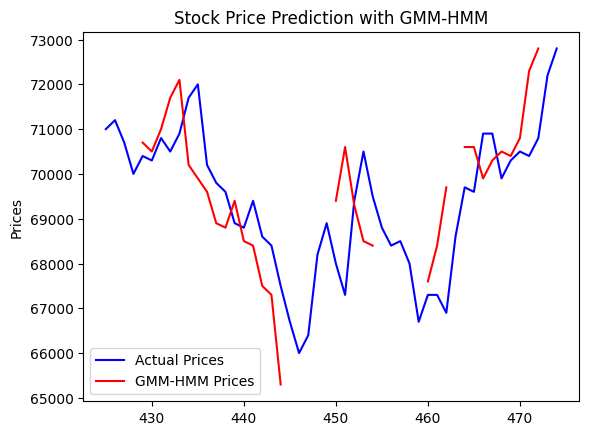

MAPE:  1.715194667698454


In [25]:
#Plot
plt.plot(df[df['Date'] > '31-08-2023']['Close'], label='Actual Prices', c='b')
plt.plot(df['PredictedPrices'], label='GMM-HMM Prices', c='r')
plt.title('Stock Price Prediction with GMM-HMM')
plt.ylabel('Prices')
plt.legend()
plt.show()

#Metrics
y_true = df[~np.isnan(df['PredictedPrices'])]['Close'].tolist()  # 실제 주가
y_pred = df[~np.isnan(df['PredictedPrices'])]['PredictedPrices'].tolist()  # GMM-HMM 모델로 예측한 주가

mape = metrics.mean_absolute_percentage_error(y_true, y_pred) * 100
print('MAPE: ', mape)


# ARIMA

#### 1.1 Data

In [ ]:
start_date = '2021-12-10'
end_date = '2023-11-17'

stock_code = '005930.KS' #Sk하이닉스: '00660.KS'
df = yf.download(stock_code, start=start_date, end=end_date)

data = df['Adj Close'][df['Volume'] != 0]

[*********************100%%**********************]  1 of 1 completed


#### 1.2 plot rolling

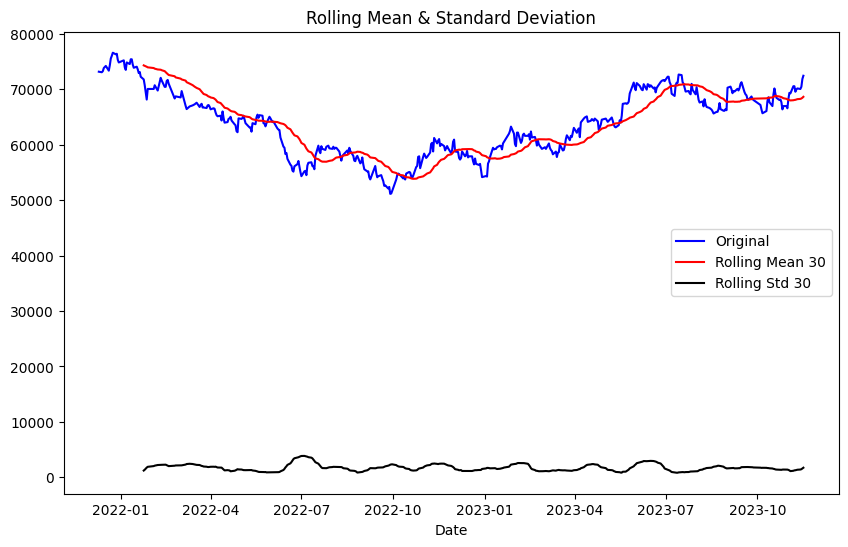

In [ ]:
def plot_rolling(data, interval):
    rolmean = data.rolling(interval).mean()
    rolstd = data.rolling(interval).std()
    #Plot rolling statistics:
    plt.figure(figsize=(10, 6))
    plt.xlabel('Date')
    orig = plt.plot(data, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean {}'.format(interval))
    std = plt.plot(rolstd, color='black', label = 'Rolling Std {}'.format(interval))
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

plot_rolling(data, 30)

#### 2.1 ADF Test

In [ ]:
def adf_test(data):
    result = adfuller(data.values)
    print('ADF Statistics: %f' % result[0])
    print('p-value: %f' % result[1])
    print('num of lags: %f' % result[2])
    print('num of observations: %f' % result[3])
    print('Critical values:')
    for k, v in result[4].items():
        print('\t%s: %.3f' % (k,v))

print('ADF TEST RESULT')
adf_test(data)

ADF TEST RESULT
ADF Statistics: -1.472993
p-value: 0.546827
num of lags: 2.000000
num of observations: 461.000000
Critical values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


#### 2.2Intergrated

<Axes: xlabel='Date'>

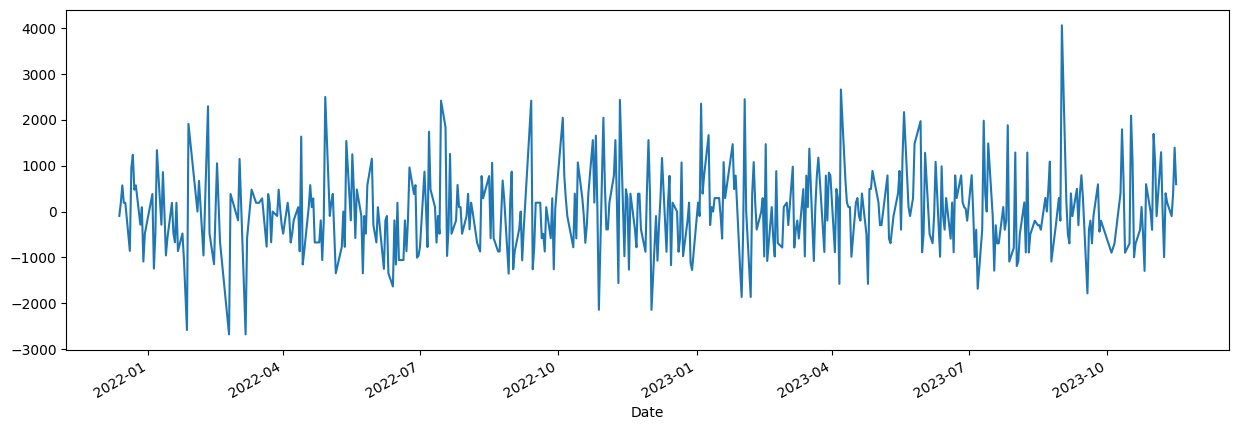

In [ ]:
dff1 = data.diff().dropna()
dff1.plot(figsize=(15,5))

In [ ]:
adf_test(dff1)

ADF Statistics: -17.501348
p-value: 0.000000
num of lags: 1.000000
num of observations: 461.000000
Critical values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


#### 2.3 ARIMA(p,d,q) parameter

In [ ]:
data = df['Close']
n_diffs = ndiffs(data, alpha=0.05, test='adf', max_d=6)
print(f"d = {n_diffs}")

d = 1


In [ ]:
model = pm.auto_arima(
            y=data,
            d=1,
            start_p=0, max_p=3,
            start_q=0, max_q=3,
            m=1, seasonal=False,
            stepwise=True,
            trace=True
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7804.218, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7806.026, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7806.029, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7802.263, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7807.794, Time=0.50 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.870 seconds


3.1 Fit Train Data

In [ ]:
train_data, test_data = data[:int(len(data)*0.9)], data[int(len(data)*0.9):]

model_fit = pm.auto_arima(
    	    y=train_data,
 	        d=n_diffs ,
            start_p=0, max_p=2,
            start_q=0, max_q=2,
            m=1, seasonal=False,
            stepwise=True,
            trace=True
)
print(model_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7021.434, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7023.078, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7023.079, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7019.526, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7024.887, Time=0.63 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.978 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  427
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3508.763
Date:                Wed, 06 Mar 2024   AIC                           7019.526
Time:                        16:31:18   BIC                           7023.581
Sample:                             0   HQIC                          7021.128
                                - 427                                       

#### 3.2 Forecast Function

In [ ]:
def forecast_n_step(model, n = 1):
    fc, conf_int = model.predict(n_periods=n, return_conf_int=True)
    # print("fc", fc,"conf_int", conf_int)
    return (
        fc.tolist()[0:n], np.asarray(conf_int).tolist()[0:n]
   )

def forecast(len, model, index, data=None):
    y_pred = []
    pred_upper = []
    pred_lower = []

    if data is not None:
        for new_ob in data:
            fc, conf = forecast_n_step(model)
            y_pred.append(fc[0])
            pred_upper.append(conf[0][1])
            pred_lower.append(conf[0][0])
            model.update(new_ob)
    else:
        for i in range(len):
            fc, conf = forecast_n_step(model)
            y_pred.append(fc[0])
            pred_upper.append(conf[0][1])
            pred_lower.append(conf[0][0])
            model.update(fc[0])
    return pd.Series(y_pred, index=index), pred_upper, pred_lower

#### 3.3 Forecast

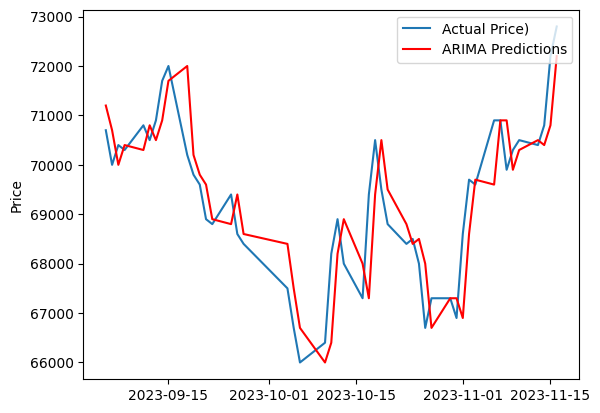

In [ ]:
fc, upper, lower = forecast(len(test_data), model_fit, test_data.index, data = test_data)

plt.plot(test_data, label='Actual Price)')
plt.plot(fc, color='red',label='ARIMA Predictions')
plt.ylabel('Price')
plt.legend(loc='upper right')
plt.show()

#### 4.1 Model Performance

In [ ]:
log_test_data = np.log(test_data)
log_fc = np.log(fc)

mape = np.mean(np.abs(np.exp(log_fc) - np.exp(log_test_data)) / np.abs(np.exp(log_test_data)))
print('MAPE: ', '{:.5f}%'.format(mape * 100))

mape = metrics.mean_absolute_percentage_error(test_data, fc) * 100
print('MAPE: ', mape)

MAPE:  0.96883%
MAPE:  0.9688288988216353
